###**Deepfake Audio Detection - Project 1 - CSCI 316**

**Group Members**

*   Advaith Sujith - 7837525
*   Rhythm Shahi - 7877304
*   Asraa Shaikh - 7859557
*   Anushka Roy - 7753226



---

Importing Metadata of the Dataset from the cloud.

In [ ]:
import shutil
from google.colab import drive

drive.mount('/content/drive')

source_csv = "/content/drive/MyDrive/modified_meta.csv"
destination_csv = "/content/"

shutil.copy(source_csv, destination_csv)

print("CSV file loaded into current directory:", destination_csv)


Mounted at /content/drive
CSV file loaded into current directory: /content/


---
Importing Raw Data as a .zip file.

In [ ]:
import shutil

source_path = "/content/drive/MyDrive/in-the-wild-dataset"
destination_path = "/content/in-the-wild-dataset"

shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print("Dataset loaded into current directory:", destination_path)


Dataset loaded into current directory: /content/in-the-wild-dataset


---
Unzipping the file

In [ ]:
import os
import zipfile

zip_file_path = "/content/in-the-wild-dataset/download"
extract_to = "/content/in-the-wild-dataset/"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Dataset successfully unzipped to:", extract_to)


Dataset successfully unzipped to: /content/in-the-wild-dataset/


In [ ]:
!ls -lh /content/in-the-wild-dataset

total 7.7G
-rw------- 1 root root 7.7G Feb  4 10:30 download
drwxr-xr-x 2 root root 932K Feb  7 11:43 release_in_the_wild


---
Importing some necessary libraries.

In [168]:
import os
import librosa
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
import joblib

---
This is the metadata. This file contains the audio name and it's corresponding label.

In [ ]:
metadata = pd.read_csv("/content/modified_meta.csv")
metadata.head(10)

file label
0  0.wav  fake
1  1.wav  fake
2  2.wav  fake
3  3.wav  fake
4  4.wav  real
5  5.wav  real
6  6.wav  fake
7  7.wav  real
8  8.wav  real
9  9.wav  real

---
Now we use Spark to extract the files into a list for feature extraction.

In [ ]:
fileListing = SparkSession.builder \
    .appName("File Listing") \
    .getOrCreate()

sc = fileListing.sparkContext

def list_files(directory):
    return [os.path.join(root, file)
            for root, _, files in os.walk(directory)
            for file in files if file.endswith(".wav")]


directories = ["/content/in-the-wild-dataset/release_in_the_wild"]
rdd = sc.parallelize(directories)

files = rdd.flatMap(list_files).collect()

print(files[:10])

['/content/in-the-wild-dataset/release_in_the_wild/7087.wav', '/content/in-the-wild-dataset/release_in_the_wild/16413.wav', '/content/in-the-wild-dataset/release_in_the_wild/3097.wav', '/content/in-the-wild-dataset/release_in_the_wild/26860.wav', '/content/in-the-wild-dataset/release_in_the_wild/30330.wav', '/content/in-the-wild-dataset/release_in_the_wild/6660.wav', '/content/in-the-wild-dataset/release_in_the_wild/27961.wav', '/content/in-the-wild-dataset/release_in_the_wild/25779.wav', '/content/in-the-wild-dataset/release_in_the_wild/7764.wav', '/content/in-the-wild-dataset/release_in_the_wild/8802.wav']


---
This function iterates through each second of the audio file and extracts relevant features.


In [ ]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    frame_length = sr
    hop_length = sr

    data = []
    for i in range(0, len(y) - frame_length, hop_length):
        segment = y[i:i + frame_length]
        if len(segment) < frame_length:
            break

        chromagram = librosa.feature.chroma_stft(y=segment, sr=sr)
        rms = librosa.feature.rms(y=segment)
        spectral_centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=segment)
        mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20)

        row = {
            "File": os.path.basename(file_path),
            "Chromagram Mean": np.mean(chromagram),
            "RMS Mean": np.mean(rms),
            "Spectral Centroid Mean": np.mean(spectral_centroid),
            "Spectral Bandwidth Mean": np.mean(spectral_bandwidth),
            "Rolloff Mean": np.mean(rolloff),
            "Zero Crossing Rate Mean": np.mean(zero_crossing_rate),
        }
        for j in range(20):
            row[f"MFCC{j + 1} Mean"] = np.mean(mfccs[j])

        data.append(row)

    return data

---
We use Spark to call the function for each second of all the audio clips.

In [ ]:
featureExtraction = SparkSession.builder \
    .appName("Feature Extraction") \
    .getOrCreate()

sc = featureExtraction.sparkContext

rdd = sc.parallelize(files)

all_features = rdd.flatMap(extract_features).collect()

df_features = pd.DataFrame(all_features)

df_features.head(10)

File  Chromagram Mean  RMS Mean  Spectral Centroid Mean  \
0   7087.wav         0.438093  0.037651             1156.916052   
1   7087.wav         0.414155  0.027880             1414.064983   
2  16413.wav         0.437100  0.068785             1004.367598   
3  16413.wav         0.376398  0.096877             1919.243814   
4  16413.wav         0.393395  0.069560              774.704250   
5  16413.wav         0.475537  0.021834              820.509776   
6  16413.wav         0.439405  0.091957             1118.475907   
7  16413.wav         0.448126  0.063371             1429.194497   
8  16413.wav         0.315416  0.099344              865.433233   
9  16413.wav         0.390631  0.086723             1484.035130   

   Spectral Bandwidth Mean  Rolloff Mean  Zero Crossing Rate Mean  MFCC1 Mean  \
0              1199.837587   2162.109375                 0.084137 -404.696106   
1              1231.035169   2358.398438                 0.127899 -376.825256   
2              1184.027114   1901.367188                 0.067673 -301.888062   
3              1599.381701   3368.408203                 0.158493 -183.377289   
4              1036.519199   1322.753906                 0.045959 -286.646057   
5              1217.727791   1506.103516                 0.039902 -383.250916   
6              1201.570820   2091.552734                 0.072311 -217.760040   
7              1300.293779   2448.242188                 0.109406 -290.335632   
8               953.569850   1555.419922                 0.052582 -250.114685   
9              1358.665453   2675.537109                 0.113602 -233.046555   

   MFCC2 Mean  MFCC3 Mean  ...  MFCC11 Mean  MFCC12 Mean  MFCC13 Mean  \
0  115.215889   16.393261  ...     3.664756    -2.822204    -3.671607   
1  125.450623   23.499084  ...     2.407843    -1.026349    -4.502721   
2  150.745041   10.524234  ...   -13.866309    -7.656408     6.541681   
3  102.254654   22.708687  ...   -21.314392    -6.216695     0.698770   
4  161.834976   15.837957  ...   -11.576447    -8.652105     0.302382   
5  145.671631   15.826935  ...    -9.043213    -8.023706    -0.010732   
6  149.622375   -4.493623  ...   -11.153376   -10.634223     0.708113   
7  122.512573   34.057121  ...   -16.333914   -10.248334    -1.939545   
8  183.949203    5.050427  ...    -4.347356   -13.689528    -4.554780   
9  116.149704   19.003180  ...   -17.774082    -6.073418     2.228022   

   MFCC14 Mean  MFCC15 Mean  MFCC16 Mean  MFCC17 Mean  MFCC18 Mean  \
0     6.822784   -15.871954    -0.842280    -8.049664    -5.645511   
1    10.441095   -25.354418    -1.842920    -9.592536    -1.893345   
2     4.750701    -6.865204    -6.868876    -7.415215    -2.558252   
3    -1.526955    -8.683259    -4.774204    -9.400639    -3.006485   
4     0.842253   -10.049240    -9.053265    -9.949270    -6.372657   
5    -1.528908    -9.567287    -4.267643    -3.670510    -5.438560   
6    -1.519034    -6.873761    -4.324493    -5.944586    -3.365569   
7     0.425724    -7.295191    -3.207687    -8.549170    -3.679999   
8    -2.373687    -7.971854    -6.976267   -12.485938    -8.910452   
9    -1.667763    -8.935110    -0.067290    -7.522285    -3.574285   

   MFCC19 Mean  MFCC20 Mean  
0    -0.527239    -4.774361  
1     0.719509    -4.719646  
2    -3.892795    -6.898397  
3    -8.388496    -7.827132  
4    -6.754607    -2.238387  
5    -3.632923    -1.526528  
6    -5.746704    -1.969600  
7    -3.629807    -4.092621  
8    -5.232218    -1.910001  
9    -7.220720    -3.849869  

[10 rows x 27 columns]

---
The table above doesn't have the labels yet so we will merge it with the metadata.

In [173]:
labeled_seconds = pd.merge(df_features, metadata, left_on='File', right_on='file', how='left')
labeled_seconds.drop(columns=['file'], inplace=True)

labeled_seconds.head(10)

File  Chromagram Mean  RMS Mean  Spectral Centroid Mean  \
0   7087.wav         0.438093  0.037651             1156.916052   
1   7087.wav         0.414155  0.027880             1414.064983   
2  16413.wav         0.437100  0.068785             1004.367598   
3  16413.wav         0.376398  0.096877             1919.243814   
4  16413.wav         0.393395  0.069560              774.704250   
5  16413.wav         0.475537  0.021834              820.509776   
6  16413.wav         0.439405  0.091957             1118.475907   
7  16413.wav         0.448126  0.063371             1429.194497   
8  16413.wav         0.315416  0.099344              865.433233   
9  16413.wav         0.390631  0.086723             1484.035130   

   Spectral Bandwidth Mean  Rolloff Mean  Zero Crossing Rate Mean  MFCC1 Mean  \
0              1199.837587   2162.109375                 0.084137 -404.696106   
1              1231.035169   2358.398438                 0.127899 -376.825256   
2              1184.027114   1901.367188                 0.067673 -301.888062   
3              1599.381701   3368.408203                 0.158493 -183.377289   
4              1036.519199   1322.753906                 0.045959 -286.646057   
5              1217.727791   1506.103516                 0.039902 -383.250916   
6              1201.570820   2091.552734                 0.072311 -217.760040   
7              1300.293779   2448.242188                 0.109406 -290.335632   
8               953.569850   1555.419922                 0.052582 -250.114685   
9              1358.665453   2675.537109                 0.113602 -233.046555   

   MFCC2 Mean  MFCC3 Mean  ...  MFCC12 Mean  MFCC13 Mean  MFCC14 Mean  \
0  115.215889   16.393261  ...    -2.822204    -3.671607     6.822784   
1  125.450623   23.499084  ...    -1.026349    -4.502721    10.441095   
2  150.745041   10.524234  ...    -7.656408     6.541681     4.750701   
3  102.254654   22.708687  ...    -6.216695     0.698770    -1.526955   
4  161.834976   15.837957  ...    -8.652105     0.302382     0.842253   
5  145.671631   15.826935  ...    -8.023706    -0.010732    -1.528908   
6  149.622375   -4.493623  ...   -10.634223     0.708113    -1.519034   
7  122.512573   34.057121  ...   -10.248334    -1.939545     0.425724   
8  183.949203    5.050427  ...   -13.689528    -4.554780    -2.373687   
9  116.149704   19.003180  ...    -6.073418     2.228022    -1.667763   

   MFCC15 Mean  MFCC16 Mean  MFCC17 Mean  MFCC18 Mean  MFCC19 Mean  \
0   -15.871954    -0.842280    -8.049664    -5.645511    -0.527239   
1   -25.354418    -1.842920    -9.592536    -1.893345     0.719509   
2    -6.865204    -6.868876    -7.415215    -2.558252    -3.892795   
3    -8.683259    -4.774204    -9.400639    -3.006485    -8.388496   
4   -10.049240    -9.053265    -9.949270    -6.372657    -6.754607   
5    -9.567287    -4.267643    -3.670510    -5.438560    -3.632923   
6    -6.873761    -4.324493    -5.944586    -3.365569    -5.746704   
7    -7.295191    -3.207687    -8.549170    -3.679999    -3.629807   
8    -7.971854    -6.976267   -12.485938    -8.910452    -5.232218   
9    -8.935110    -0.067290    -7.522285    -3.574285    -7.220720   

   MFCC20 Mean  label  
0    -4.774361   fake  
1    -4.719646   fake  
2    -6.898397   real  
3    -7.827132   real  
4    -2.238387   real  
5    -1.526528   real  
6    -1.969600   real  
7    -4.092621   real  
8    -1.910001   real  
9    -3.849869   real  

[10 rows x 28 columns]

---
The data is unbalanced. To fix this, we will undersample real to the same amount of data as fake (55677)

In [174]:
labeled_seconds["label"].value_counts()

label
real    64687
fake    55677
Name: count, dtype: int64

In [175]:
df = labeled_seconds.copy()

In [176]:
df_fake = df[df["label"] == "fake"]
df_real = df[df["label"] == "real"]

df_downsampled = resample(df_real, replace=False, n_samples=55677, random_state=42)

df_combined = pd.concat([df_downsampled, df_fake], ignore_index=True)

df_notfinal = df_combined.sample(frac=1, random_state=42)

df_notfinal["label"].value_counts()

label
real    55677
fake    55677
Name: count, dtype: int64

In [177]:
df_notfinal.head(10)

File  Chromagram Mean  RMS Mean  Spectral Centroid Mean  \
26381   7646.wav         0.248310  0.046761             1907.562493   
45403  22298.wav         0.287063  0.012341             2083.978699   
32415  21593.wav         0.483268  0.023015             1736.287053   
27381  29006.wav         0.355944  0.081647             1211.421166   
61697   7532.wav         0.325397  0.062967              823.996626   
59601  28867.wav         0.325876  0.014084              976.226595   
31981  24729.wav         0.355245  0.010019             1753.733532   
72363  20694.wav         0.274529  0.063468              636.107064   
23919  30966.wav         0.302547  0.024038             2102.661169   
7119   21432.wav         0.303257  0.014117             1458.844846   

       Spectral Bandwidth Mean  Rolloff Mean  Zero Crossing Rate Mean  \
26381              1700.834008   3782.958984                 0.111328   
45403              1658.191884   3514.404297                 0.133301   
32415              1714.744539   3309.326172                 0.107117   
27381              1409.530448   2250.732422                 0.088669   
61697              1115.389602   1534.912109                 0.063736   
59601              1191.343372   2111.083984                 0.057816   
31981              1459.894729   2878.417969                 0.144852   
72363               642.713701   1009.765625                 0.040329   
23919              1900.453212   4154.541016                 0.136551   
7119               1789.666288   3268.554688                 0.066727   

       MFCC1 Mean  MFCC2 Mean  MFCC3 Mean  ...  MFCC12 Mean  MFCC13 Mean  \
26381 -264.101807   49.692032  -35.480137  ...     4.696817    -8.221034   
45403 -398.472534   61.340759    6.175031  ...     6.165838    -5.235308   
32415 -306.304108   91.507286  -23.689671  ...    -5.988667   -16.751875   
27381 -245.123276  134.570694   10.923199  ...     5.489872    -8.771734   
61697 -352.216614  157.473053   12.602050  ...    -4.307262    -5.218086   
59601 -502.421204  122.901703  -12.818611  ...     2.088876     6.459835   
31981 -386.752991   99.449677  -21.081913  ...     1.178267   -13.374164   
72363 -316.482819  206.464661  -13.683283  ...   -20.799541    -7.308172   
23919 -314.299438   62.443954   16.199879  ...    -7.866531   -12.402759   
7119  -437.548218   97.428307   12.617407  ...    -6.167593   -14.268351   

       MFCC14 Mean  MFCC15 Mean  MFCC16 Mean  MFCC17 Mean  MFCC18 Mean  \
26381    -4.851034    -8.636367   -16.244179   -17.560593   -18.902752   
45403     4.367728   -11.295658    -3.193956    -8.030152   -13.839947   
32415    11.860352    -6.085680     3.133209     3.843026     0.887771   
27381     9.873770    -4.740385     1.056166    -3.195197    -8.118413   
61697     4.023111   -15.902721    -4.301584    -9.267918    -3.582959   
59601     0.163973    -7.706666    -2.727213    -3.659874    -2.498780   
31981    -6.478364     2.361522   -10.463160    -6.935797     3.594893   
72363    -9.123414   -13.947848    -5.919518   -15.587723    -6.901053   
23919    -3.096680    -7.066228    -3.610039    -4.804824    -1.388579   
7119     -4.100886    -4.506065    -8.156210    -2.890338    -6.300369   

       MFCC19 Mean  MFCC20 Mean  label  
26381   -20.728703   -11.545187   real  
45403    -4.128798    -4.401389   real  
32415     2.781466     1.212646   real  
27381    -5.295989    -5.119584   real  
61697    -2.807384    -3.090307   fake  
59601     7.437632     0.107599   fake  
31981   -14.992363     2.502426   real  
72363    -9.077056    -7.828008   fake  
23919   -13.771003    -5.976290   real  
7119    -12.616280    -0.963198   real  

[10 rows x 28 columns]

---
# Unsupervised learning

Feature Importance

In [181]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

rf = RandomForestClassifier(random_state=42)
X = df_notfinal.drop(columns=['label','File'])
y = df_notfinal['label']
rf.fit(X, y)

importance = rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                    Feature  Importance
20              MFCC15 Mean    0.145525
6                MFCC1 Mean    0.119223
24              MFCC19 Mean    0.079972
3   Spectral Bandwidth Mean    0.065459
15              MFCC10 Mean    0.064517
1                  RMS Mean    0.055113
16              MFCC11 Mean    0.052437
19              MFCC14 Mean    0.043119
23              MFCC18 Mean    0.032628
13               MFCC8 Mean    0.029541
7                MFCC2 Mean    0.026734
8                MFCC3 Mean    0.025848
22              MFCC17 Mean    0.025397
10               MFCC5 Mean    0.024476
21              MFCC16 Mean    0.023504
5   Zero Crossing Rate Mean    0.021404
12               MFCC7 Mean    0.020647
0           Chromagram Mean    0.018998
17              MFCC12 Mean    0.018577
11               MFCC6 Mean    0.018543
18              MFCC13 Mean    0.017700
9                MFCC4 Mean    0.016668
14               MFCC9 Mean    0.014152
4              Rolloff Mean    0.013592


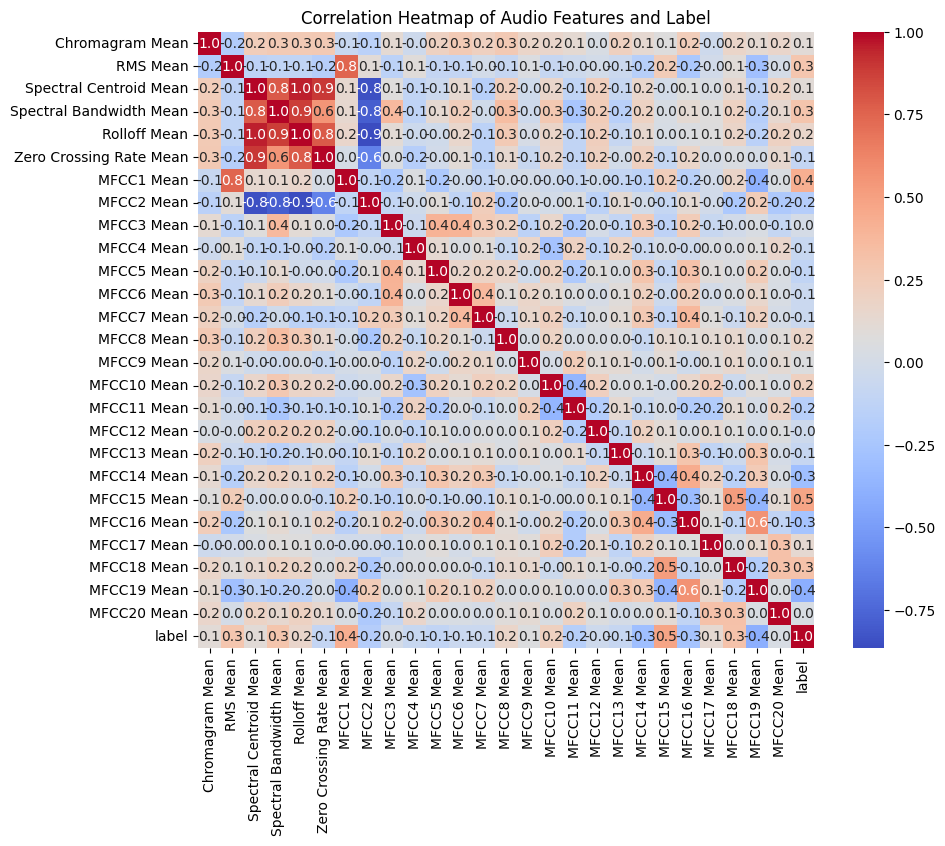

In [ ]:
correlation_matrix = df_notfinal.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".1f",square=True)
plt.title("Correlation Heatmap of Audio Features and Label")
plt.show()

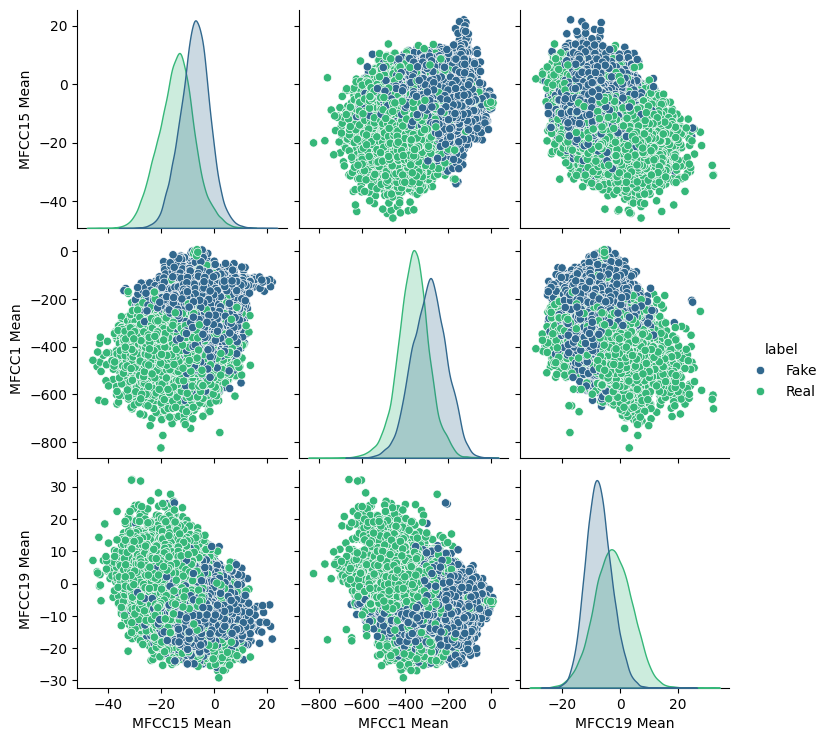

In [66]:
df_final_forsns=df_notfinal

features_to_plot = df_final_forsns[['MFCC15 Mean', 'MFCC1 Mean', 'MFCC19 Mean', 'label']]

sns.pairplot(features_to_plot, hue='label', palette='viridis')

plt.show()


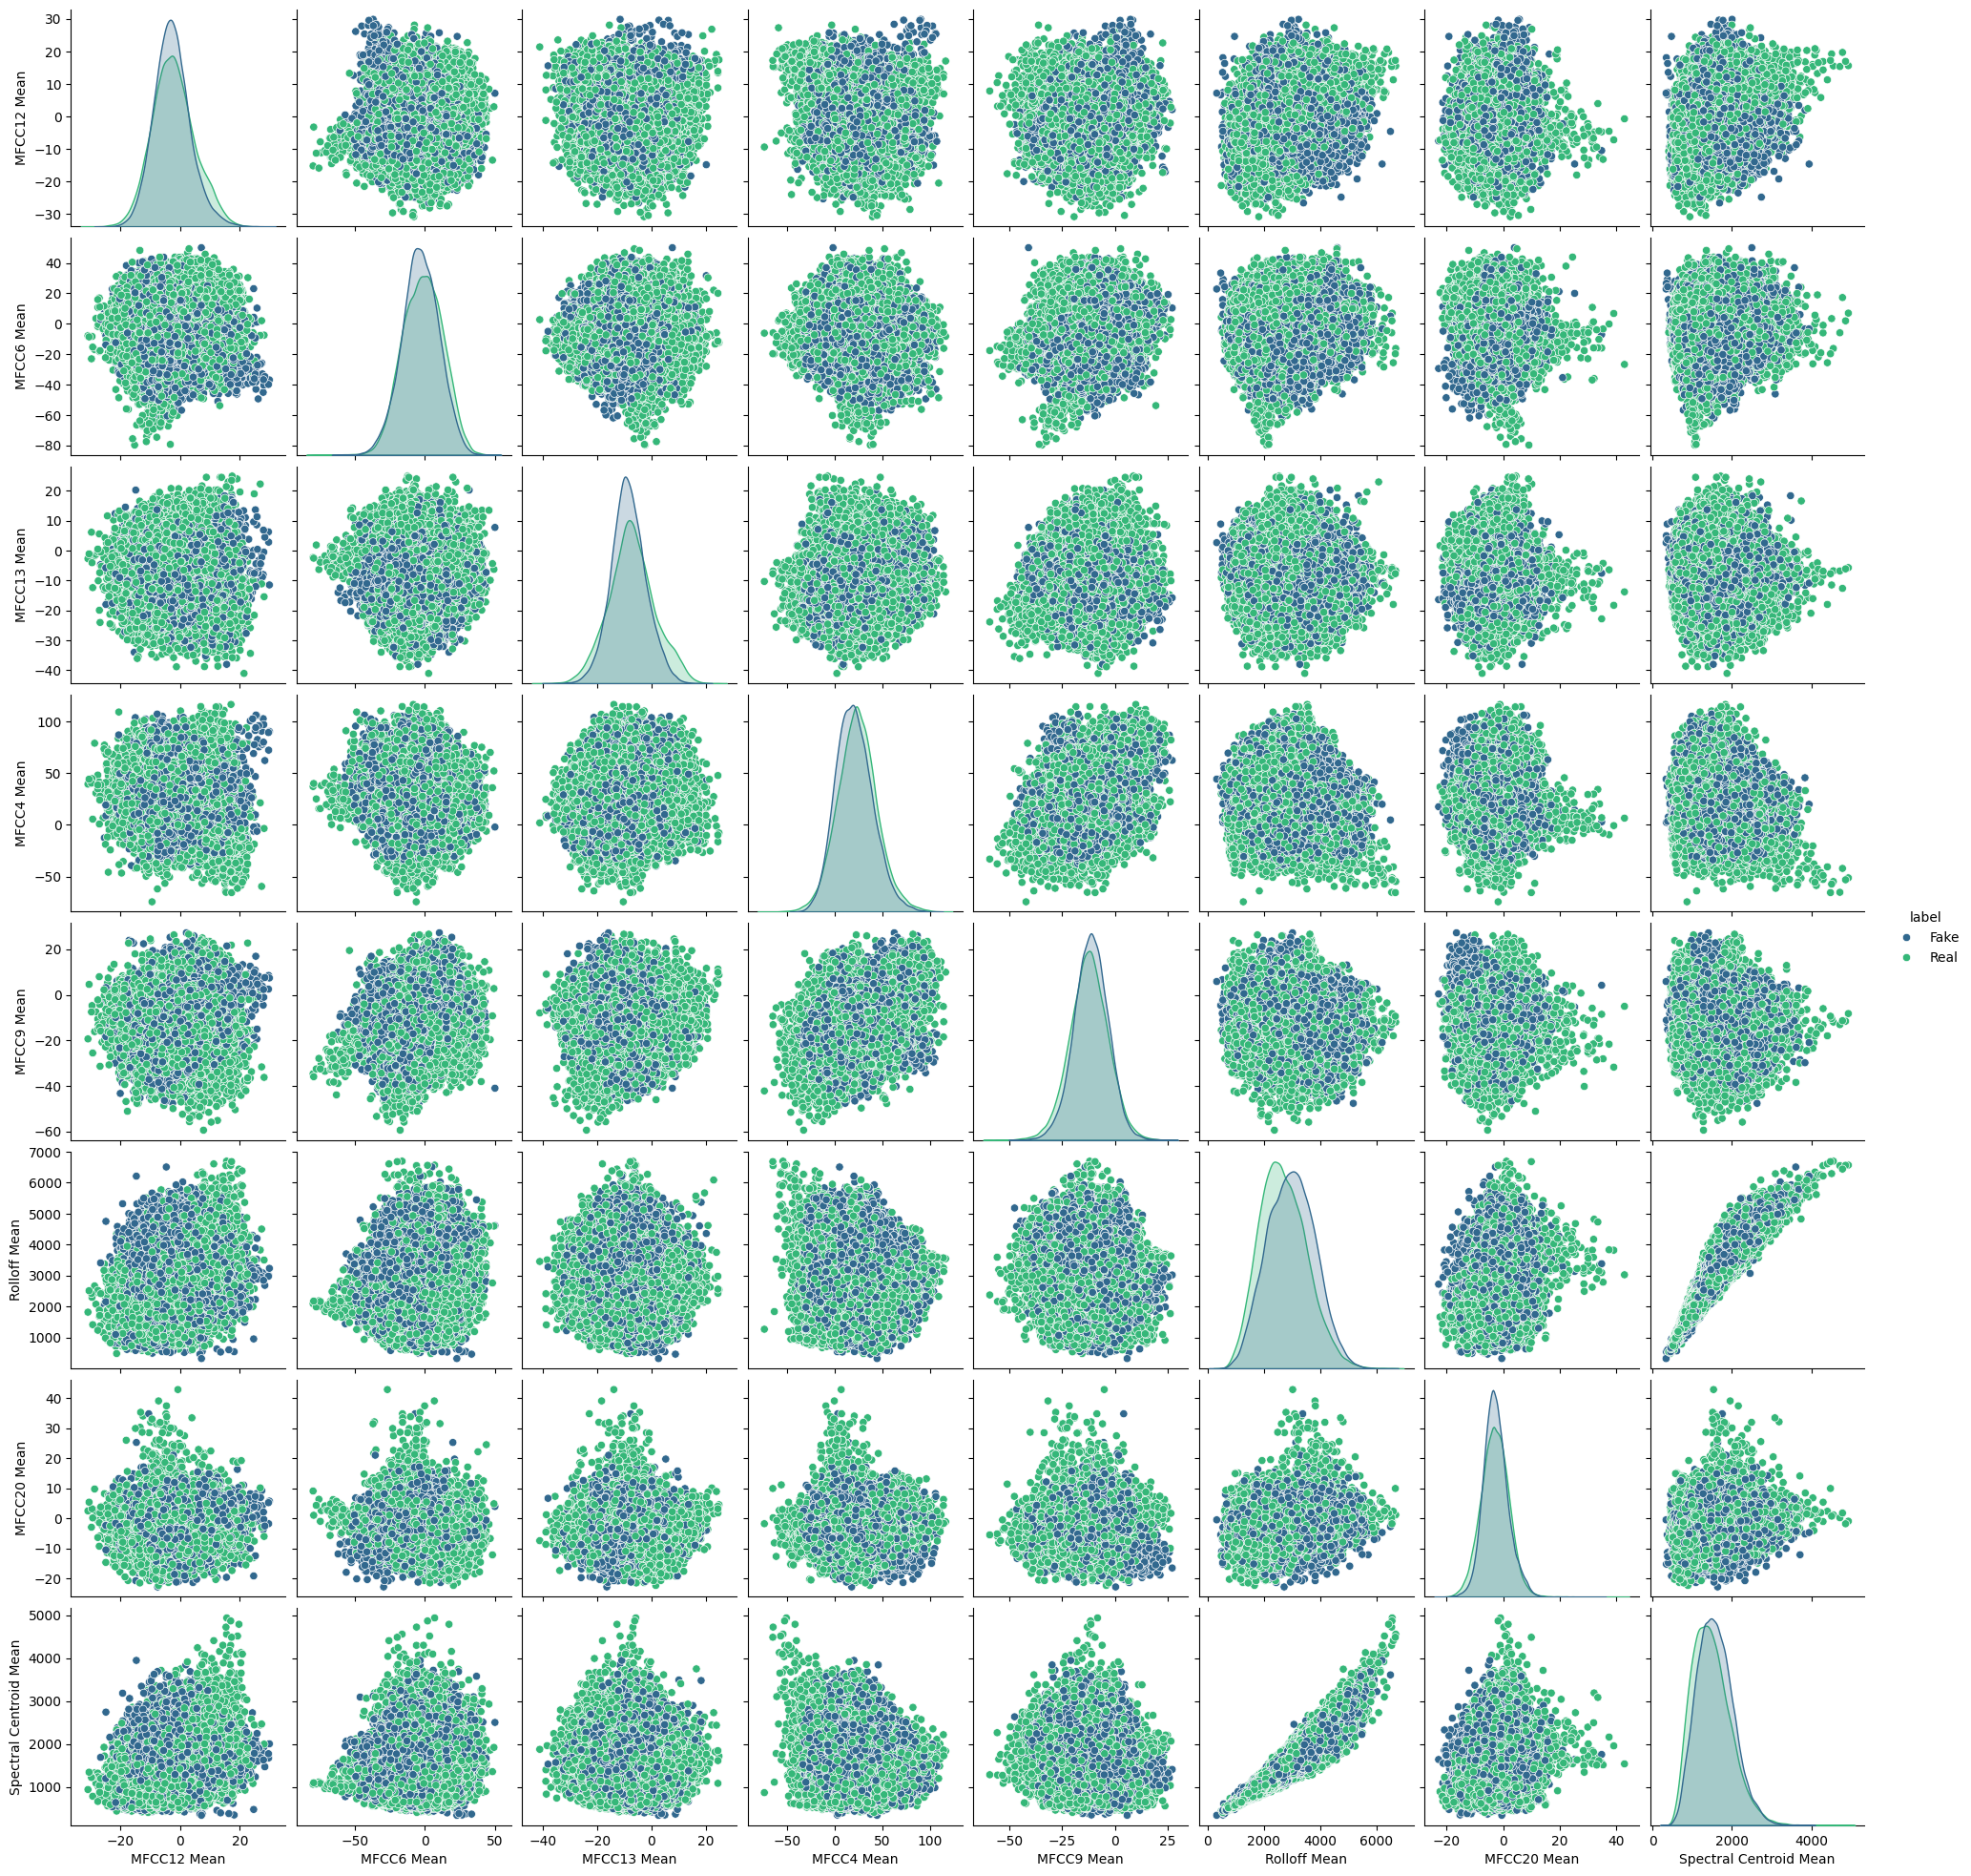

In [107]:
df_final_forsns=df_notfinal

df_final_forsns['label'] = df_notfinal['label'].replace({0: 'Real', 1: 'Fake'})

features_to_plot = df_final_forsns[['MFCC12 Mean','MFCC6 Mean', 'MFCC13 Mean', 'MFCC4 Mean', 'MFCC9 Mean', 'Rolloff Mean','MFCC20 Mean','Spectral Centroid Mean','label']]

sns.pairplot(features_to_plot, hue='label', palette='viridis')

plt.show()

In [153]:
df_notfinal.drop(columns=['MFCC12 Mean','MFCC6 Mean', 'MFCC13 Mean', 'MFCC4 Mean', 'MFCC9 Mean', 'Rolloff Mean','MFCC20 Mean','Spectral Centroid Mean'],inplace=True)

In [154]:
df_notfinal['label'] = df_notfinal['label'].map({'real': 1, 'fake': 0})
df_final = df_notfinal.drop(columns=["File"])

In [137]:
df_final.to_csv("final_df.csv", index=False)

In [103]:
from google.colab import drive

drive.mount('/content/drive')

destination_csv = "/content/drive/MyDrive/"
source_csv = "final_df.csv"


shutil.copy(source_csv, destination_csv)


print("File saved successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File saved successfully!


---

Saving the csv file

In [105]:
import shutil

source_csv = "/content/drive/MyDrive/final_df.csv"
destination_csv = "/content/"

shutil.copy(source_csv, destination_csv)

print("CSV file loaded into current directory:", destination_csv)


CSV file loaded into current directory: /content/


Bagging Model

In [138]:
class BaggingClassifier:
    def __init__(self, n_estimators=100):
        self.n_estimators = n_estimators
        self.estimators = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        for _ in range(self.n_estimators):
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            X_sample, y_sample = X[idxs], y[idxs]

            log_reg = LogisticRegression(max_iter=1000)
            log_reg.fit(X_sample, y_sample)
            self.estimators.append(log_reg)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.estimators])

        return np.array([self._most_common_label(p) for p in predictions.T])

    def _most_common_label(self, y):
        return np.argmax(np.bincount(y))

    def cross_validate(self, X, y, k=10):
        fold_size = len(X) // k
        indices = np.arange(len(X))
        np.random.shuffle(indices)

        fold_accuracies = []
        for i in range(k):
            test_indices = indices[i * fold_size:(i + 1) * fold_size]
            train_indices = np.setdiff1d(indices, test_indices)

            X_train, X_test = X[train_indices], X[test_indices]
            y_train, y_test = y[train_indices], y[test_indices]

            # Create a new instance of BaggingClassifier for each fold
            temp_model = BaggingClassifier(n_estimators=self.n_estimators)
            temp_model.fit(X_train, y_train)

            predictions = temp_model.predict(X_test)
            accuracy = np.mean(predictions == y_test)
            fold_accuracies.append(accuracy)

        return np.mean(fold_accuracies)

Testing

In [155]:
X = df_final.drop(columns=["label"]).values
y = df_final["label"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

bc = BaggingClassifier(n_estimators=100)

validation = bc.cross_validate(X_train, y_train)
print("10-Fold Cross Validation:", validation)

bc.fit(X_train, y_train)

predictions = bc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))

10-Fold Cross Validation: 0.882162101481814
Accuracy: 0.8806519689282026


---


Boosting model

In [164]:
class AdaBoost:
    def __init__(self, n_estimators=100, learning_rate=0.05):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimators = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        weights = np.full(n_samples, 1 / n_samples)

        for _ in range(self.n_estimators):
            weak_model = self.train_weak_model(X, y, weights)
            predictions = weak_model.predict(X)

            error = self.compute_error(y, predictions, weights)

            if error > 0.5 or error == 0:
                break

            alpha = self.compute_alpha(error)
            self.estimators.append((weak_model, alpha))

            # Update weights
            weights *= np.exp(-alpha * y * predictions)
            weights /= np.sum(weights)

    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
        for model, alpha in self.estimators:
            final_predictions += alpha * model.predict(X)
        return np.sign(final_predictions)

    def train_weak_model(self, X, y, weights):
        tree = DecisionTreeClassifier(max_depth=3)
        tree.fit(X, y, sample_weight=weights)
        return tree

    def compute_error(self, y, predictions, weights):
        return np.sum(weights * (predictions != y)) / np.sum(weights)

    def compute_alpha(self, error):
        return 0.5 * np.log((1 - error) / max(error, 1e-10))

    def cross_validate(self, X, y, k=10):
        fold_size = len(X) // k
        indices = np.arange(len(X))
        np.random.shuffle(indices)

        fold_accuracies = []
        for i in range(k):
            test_indices = indices[i * fold_size:(i + 1) * fold_size]
            train_indices = np.setdiff1d(indices, test_indices)

            X_train, X_test = X[train_indices], X[test_indices]
            y_train, y_test = y[train_indices], y[test_indices]

            self.fit(X_train, y_train)
            predictions = self.predict(X_test)
            accuracy = np.mean(predictions == y_test)
            fold_accuracies.append(accuracy)

            self.estimators = []

        return np.mean(fold_accuracies)

In [165]:
X = df_final.drop(columns=["label"]).values
y = df_final["label"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


adaboost = AdaBoost(n_estimators=100, learning_rate=0.05)
adaboost.fit(X_train, y_train)


predictions = adaboost.predict(X_test)

from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, predictions))

Accuracy: 0.8116384535943604


Bagging did better, saving bagging model to drive

In [170]:
from google.colab import drive
import tensorflow as tf

model_save_path = "/content/drive/My Drive/bagging_classifier_model.pkl"
joblib.dump(bc, model_save_path)

print(f"Model saved at {model_save_path}")


Model saved at /content/drive/My Drive/bagging_classifier_model.pkl


In [171]:
drive.flush_and_unmount()